## DenseNet as an encoder

In [1]:
# Import the necessary libraries
import os
import cv2 as cv
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [5]:
# Path of the dataset
data_path = 'C:/Windows/System32/ML_PATH/Electrothon 3.0/kaggle_transfer_learning_covid/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet201

In [6]:
# Get your train and test data
train_datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0.3,height_shift_range=0.3,shear_range=0.2,preprocessing_function=preprocess_input,validation_split=0.1,horizontal_flip=True,vertical_flip=True,zoom_range=0.2)
val_generator=train_datagen.flow_from_directory(train_dir,target_size=(224,224),class_mode='categorical',subset='validation',batch_size=3,shuffle=False)

Found 21 images belonging to 3 classes.


## Import DenseNet and load the weights

In [7]:
base_model=DenseNet201(input_shape=[224,224,3],weights='imagenet',include_top=False) 

In [11]:
x=base_model.output
base_model.trainable=False
x1=keras.layers.GlobalAveragePooling2D()(x)
x2=keras.layers.Dense(512,activation='relu')(x1)
DenseNet=keras.models.Model(inputs=[base_model.input],outputs=[x2]) #specify the inputs and outputs

We have excluded the output layer of the network. This is because we need the features from the latent space and not the outputs

In [13]:
import pickle
with open("C:/Windows/System32/ML_PATH/Electrothon 3.0/DenseNet/x2.txt", "rb") as fp:
  weightsAndBiases=pickle.load(fp)

In [14]:
DenseNet.layers[-1].set_weights(weightsAndBiases)

In [15]:
DenseNet.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])

In [17]:
labels=np.array([0.,0.,0.,0.,0.,0.,0.,1.,1.,1.,1.,1.,1.,1.,2.,2.,2.,2.,2.,2.,2.,])
features=DenseNet.predict(val_generator)

In [18]:
features.shape

(21, 512)

### Decompse latent features into two components using PCA

In [25]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca_features=pca.fit_transform(features)

In [26]:
pca.explained_variance_ratio_

array([0.36044383, 0.25491834], dtype=float32)

### Scatter plot

In [34]:
# Helper function to plot the data as clusters 

def plot3clusters(X, title, vtitle, target_names):
    plt.figure()
    
    # Select the colours of the clusters
    colors = ['#A43F98', '#5358E0', '#DE0202']
    lw = 2
    plt.figure(figsize=(9,7));
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X[7*i:7*(i+1), 0], X[7*i:7*(i+1), 1], color=color, alpha=1., lw=lw, label=target_name);
   
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title);
    plt.xlabel(vtitle + "1")
    plt.ylabel(vtitle + "2")
    plt.show();

<Figure size 432x288 with 0 Axes>

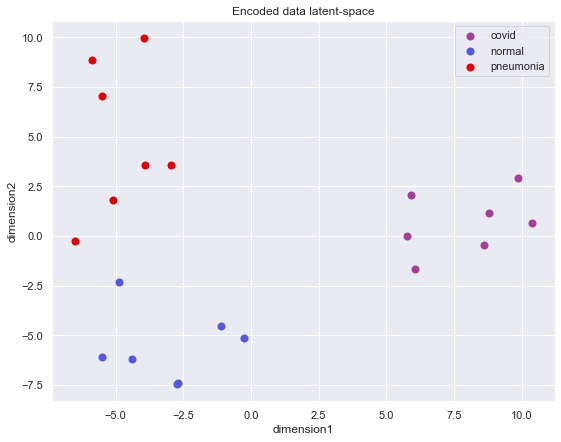

In [35]:
target_names = ['covid', 'normal', 'pneumonia']
plot3clusters(pca_features, 'Encoded data latent-space', 'dimension', target_names)

### The scatter plot shows that the features in the latent space are not entangled. This property of disentanglement is a proof of the model's good performance and since this plot is obtained from the held-out set, we can expect good performance with unseen data as well. Our model is robust and generalisable!